# Analysis of Raw PPG Signal from PineTime Watch
## Objective of the Analysis

This analysis aims to explore how to work with raw Photoplethysmogram (PPG) signals, which are typically used to monitor heart rate, blood oxygen levels, and other physiological signals. The goal is to demonstrate how this data can be processed and what insights we can extract from it. This is very simple analysis, and it is rather start and inspiration for further investigation.

## Data Source and Acquisition

The raw PPG signal was recorded from a PineTime smartwatch, where an additional BLE (Bluetooth Low Energy) service (HeartRateRawService in this fork) was added to expose the raw PPG data for analysis. The PPG signal is a measure of blood volume changes in the microvascular bed of tissue and can be influenced by various factors such as motion, skin contact, and light intensity.

## Dataset Description

Several datasets were recorded during this analysis, capturing the raw PPG signals from different activities such as rest, hand weaving, palm squeezing, and more physically intensive  actions like squats. Each dataset represents distinct physiological conditions, which provides a good foundation for exploring how the PPG signal behaves under varying circumstances. 
Datasets have downsides, like there is no explicit indicator where in time are specific activities that was done during recording. 

## Sensor Configuration and Modifications

The source of the PPG signal is the HRS3300 sensor, a green LED-based optical heart rate sensor. For this analysis, the configuration of the HRS3300 was modified to use a brighter green LED for better signal quality. Most of the datasets were recorded with this enhanced configuration (led current 40 mA), except for the last dataset, where the LED current was set to its default 12 mA setting. This will allow us to compare signal quality between higher and default brightness levels.


# Disclaimer (after analysis attempt)
The PPG algorithm used in this analysis should be improved, so the results are not fully reliable. The collected data is not suitable for proper analysis because multiple activities were performed during recording, and it is unclear when each activity started or ended. Therefore, this analysis serves more as a proof of concept, demonstrating that PPG data collection is feasible. An important limitation not covered in the analysis is that during physical activities like walking, heart rate detection is highly inaccurate. This is likely due to interference from arm movement during walking.

In [52]:
import pandas as pd
import numpy as np
import hrs_analysis_tools
import importlib
import matplotlib.pyplot as plt
import json
importlib.reload(hrs_analysis_tools)

<module 'hrs_analysis_tools' from '/home/kosttek/myShit/InfiniTime/ppg_analysis/hrs_analysis_tools.py'>

In [56]:
async def get_aggergatd_data(data_csv_path):
    dataframe = pd.read_csv(data_csv_path)
    gen = hrs_analysis_tools.dataframe_to_generator(dataframe)
    aggregated = await hrs_analysis_tools.process(gen)
    return aggregated

def get_description(metadata_path):   
   with open(metadata_path,"r") as file:
       metadata = json.load(file)
       return metadata["description"]

In [59]:
aggreaged_led40_steady_hand  = await get_aggergatd_data('data/1727532341_data.csv')
description_led40_steady_hand = get_description('data/1727532341_metadatadata.json')

aggreaged_led40_squeeze_palm = await get_aggergatd_data('data/1727535175_data.csv')
description_led40_squeeze_palm = get_description('data/1727535175_metadatadata.json')

aggreaged_led40_waving_hand  = await get_aggergatd_data('data/1727535595_data.csv')
description_led40_waving_hand = get_description('data/1727535595_metadatadata.json')

aggreaged_led40_squats_1  = await get_aggergatd_data('data/1727536786_data.csv')
description_led40_squats_1 = get_description('data/1727536786_metadatadata.json')

aggreaged_led40_squats_2  = await get_aggergatd_data('data/1727537070_data.csv')
description_led40_squats_2 = get_description('data/1727537070_metadatadata.json')

aggreaged_led12_squats_1  = await get_aggergatd_data('data/1727541509_data.csv')
description_led12_squats_1 = get_description('data/1727541509_metadatadata.json')


## Data overview
Below you can see few data recordings. Most of them were done with increased led current (40 mA). Last one (purple) was made with default low led current (12 mA). When current is bigger then led green light is brighter. In plot legend you can find descriptions of activities that were done during ppg signal recording.

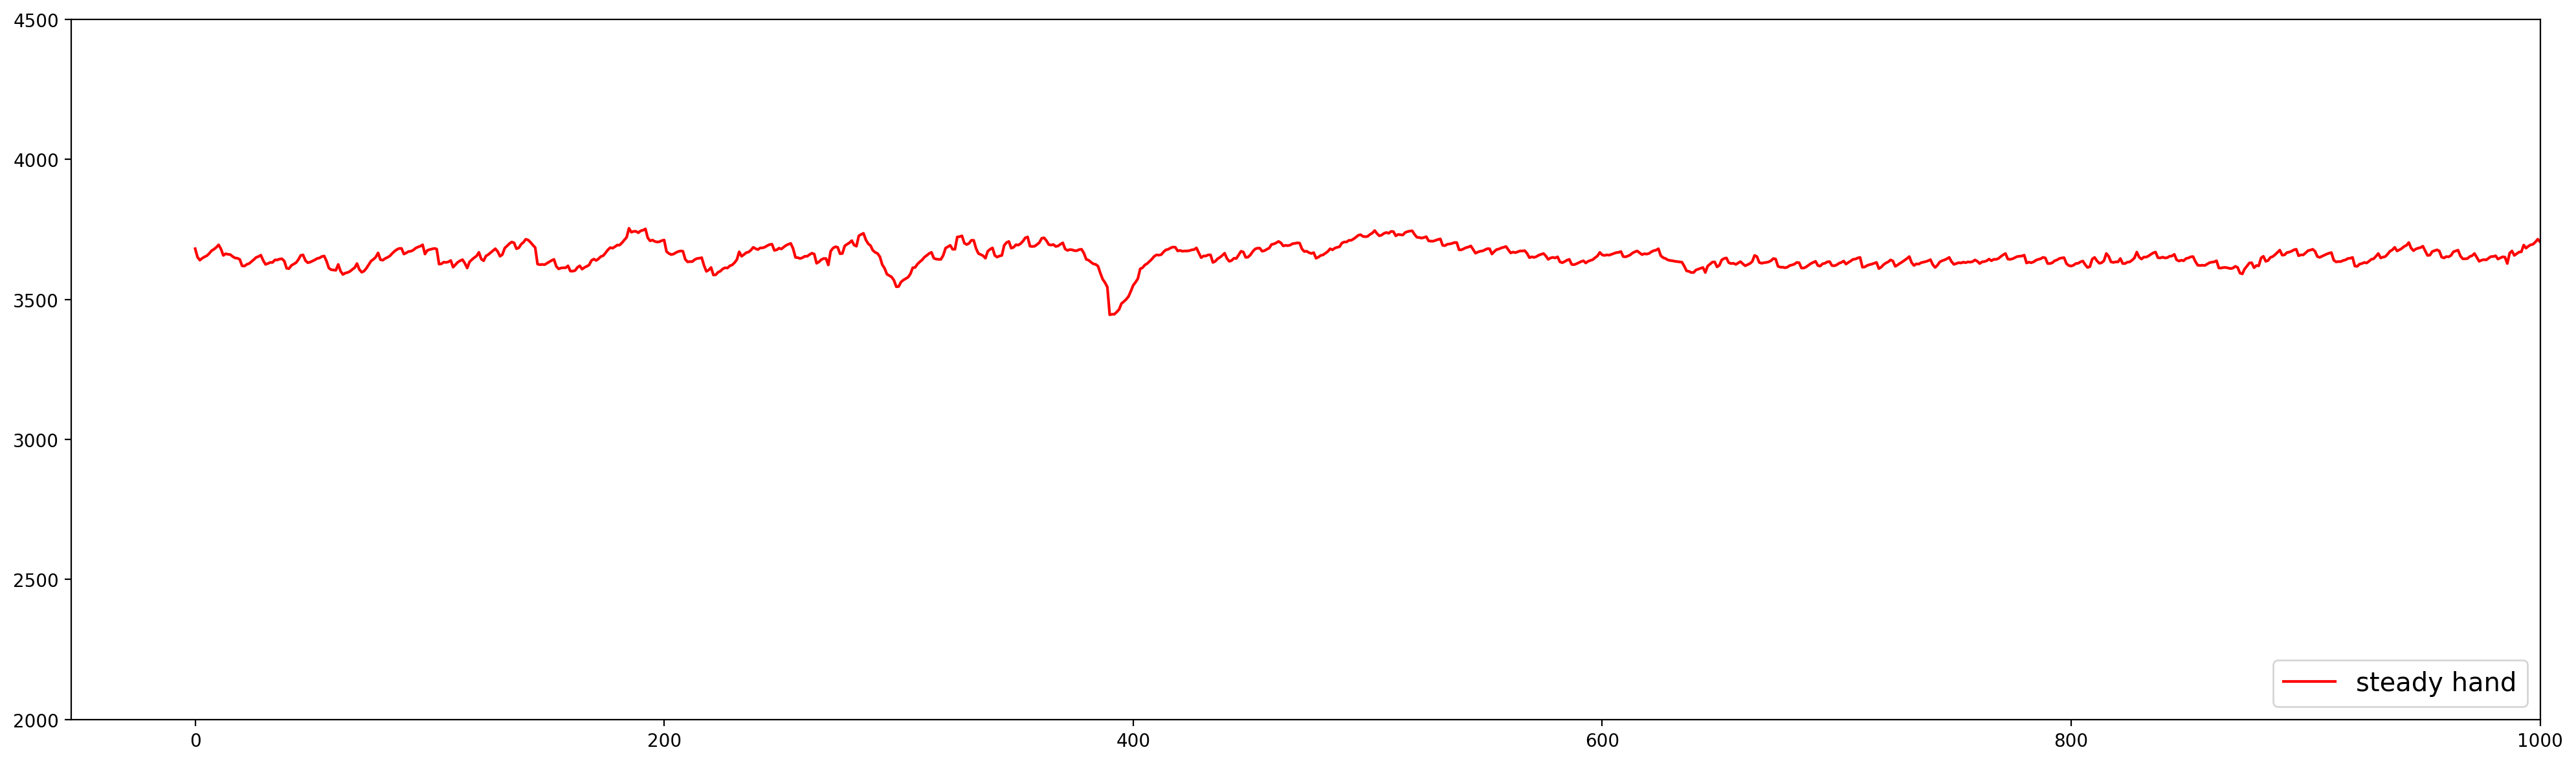

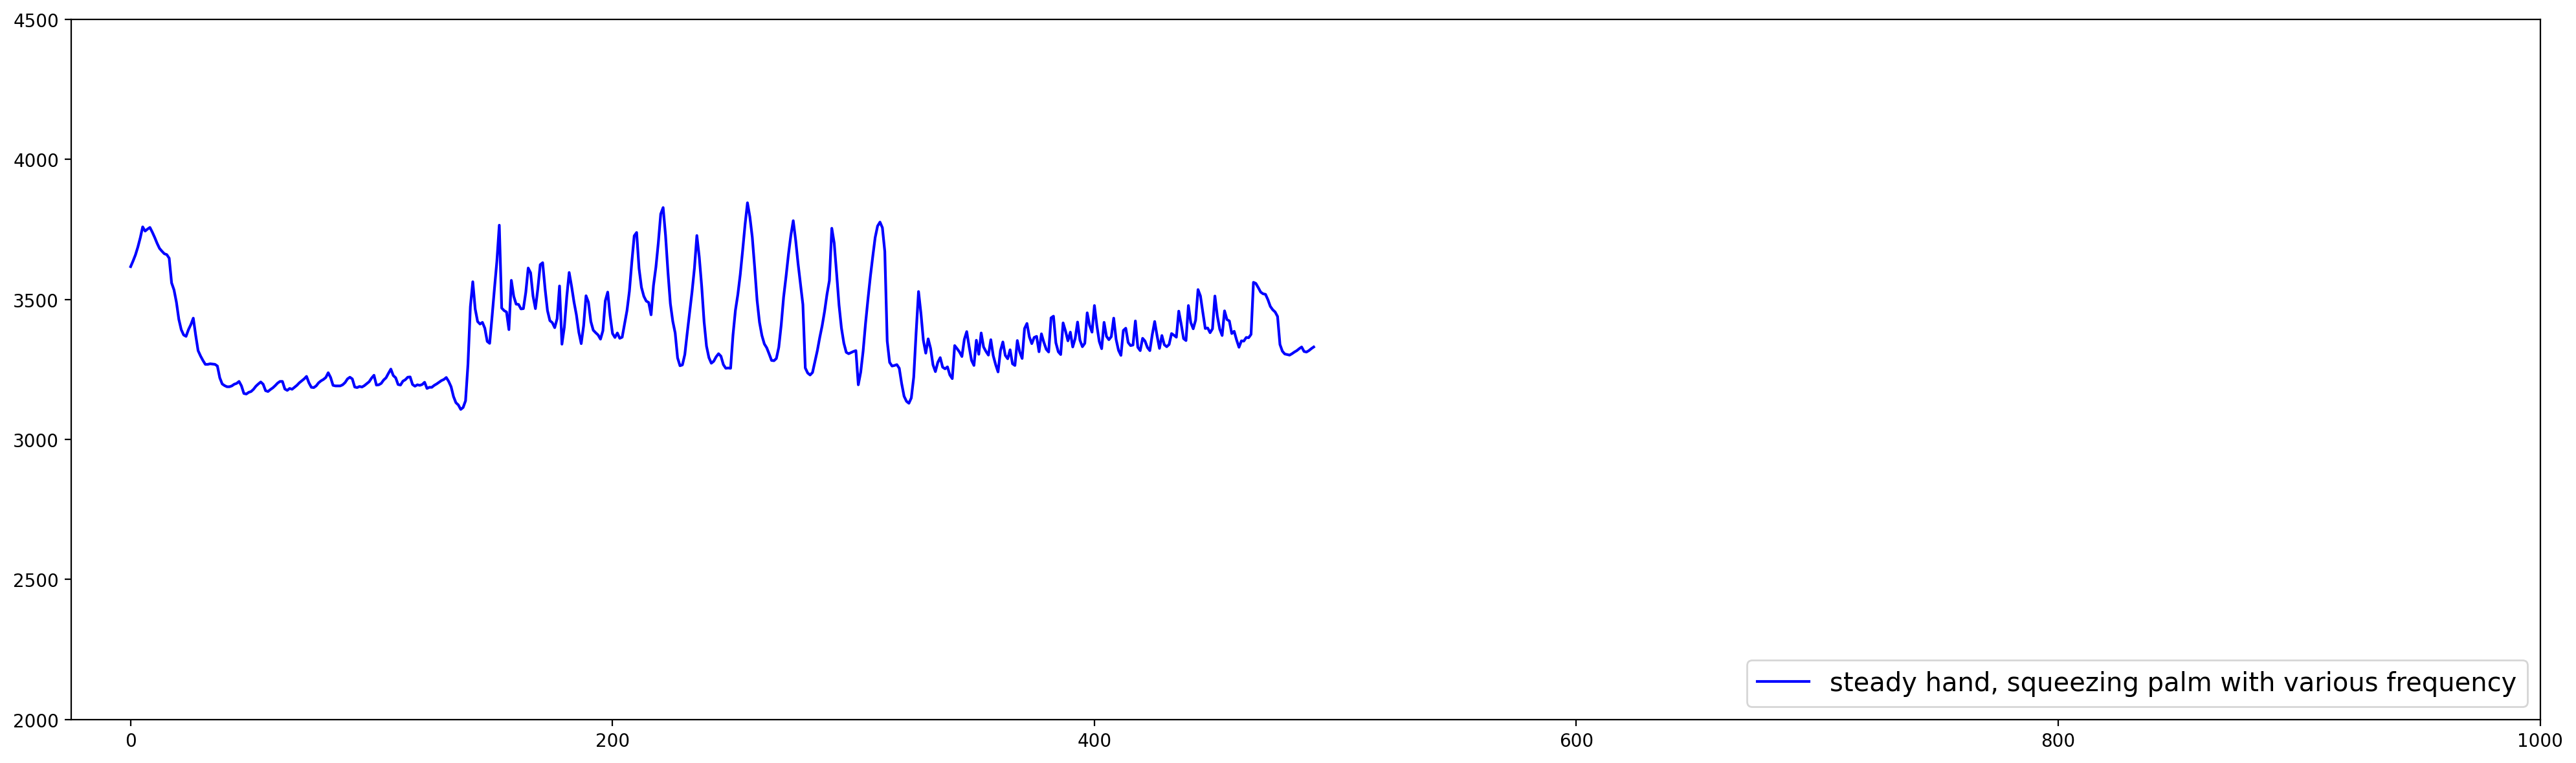

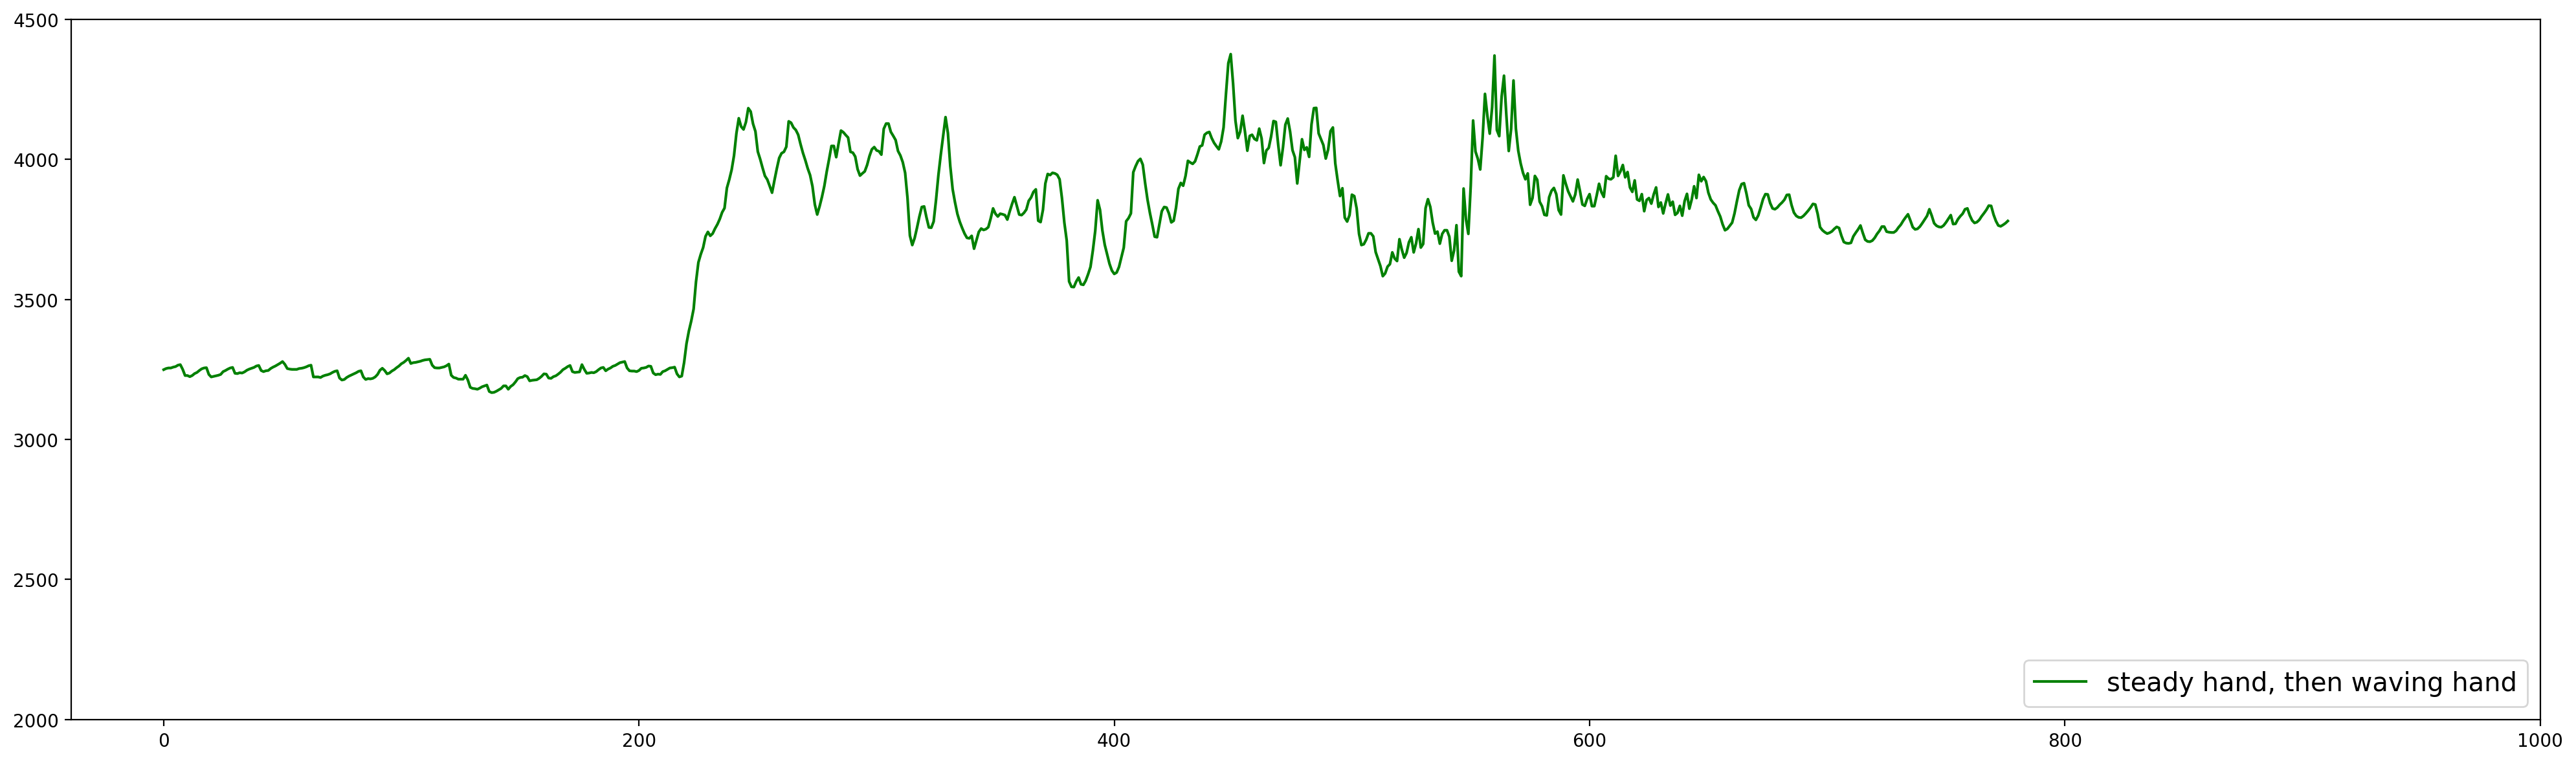

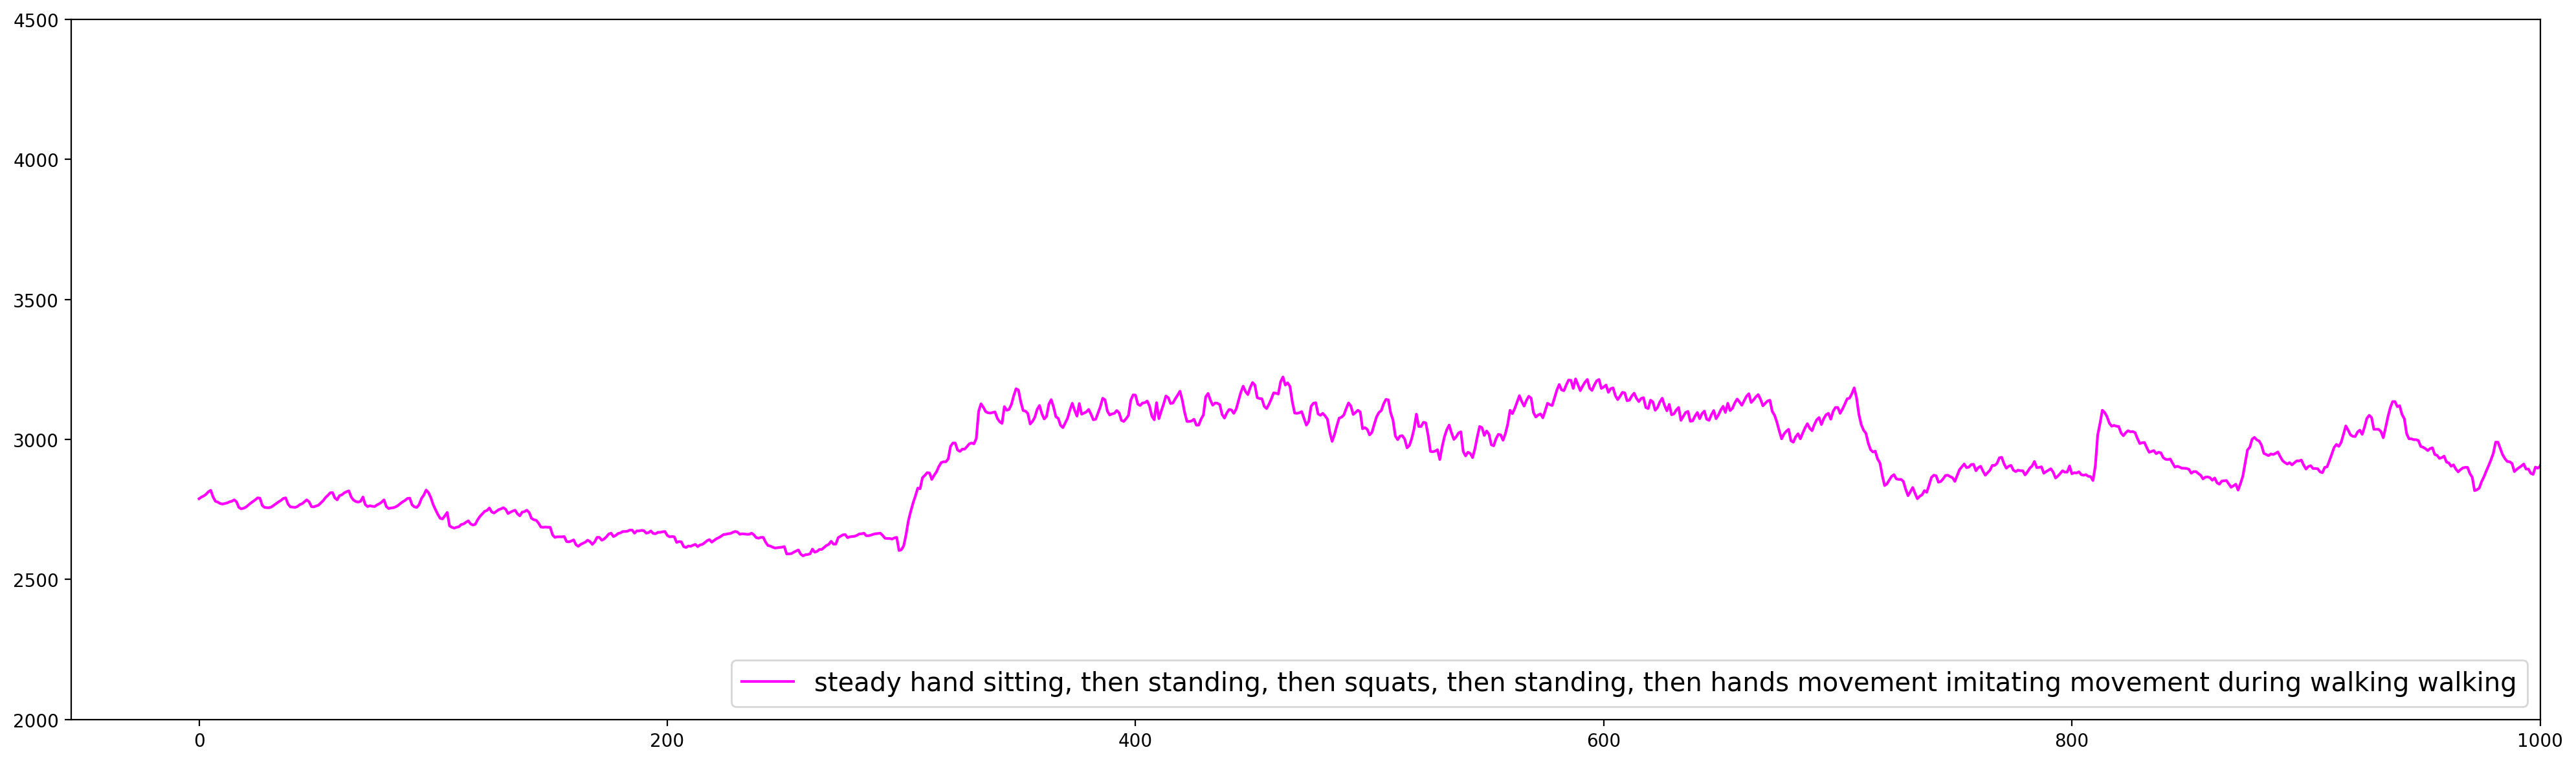

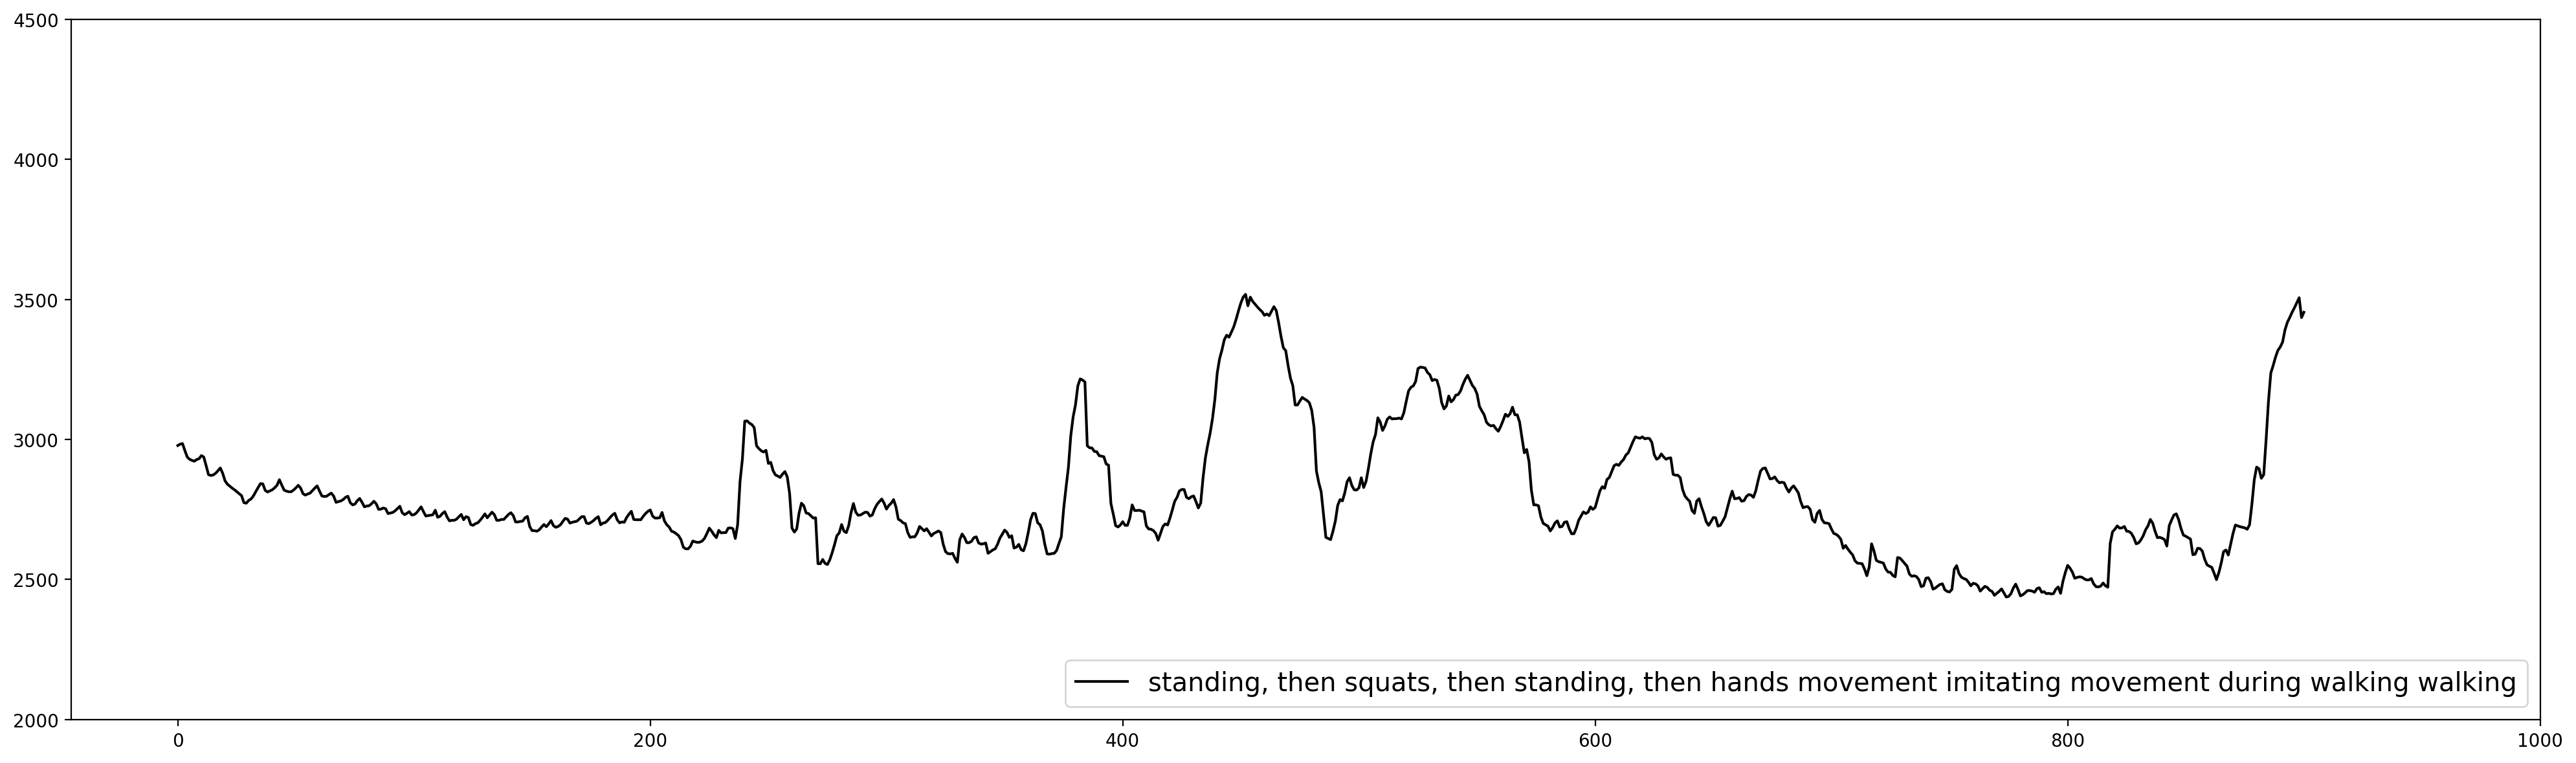

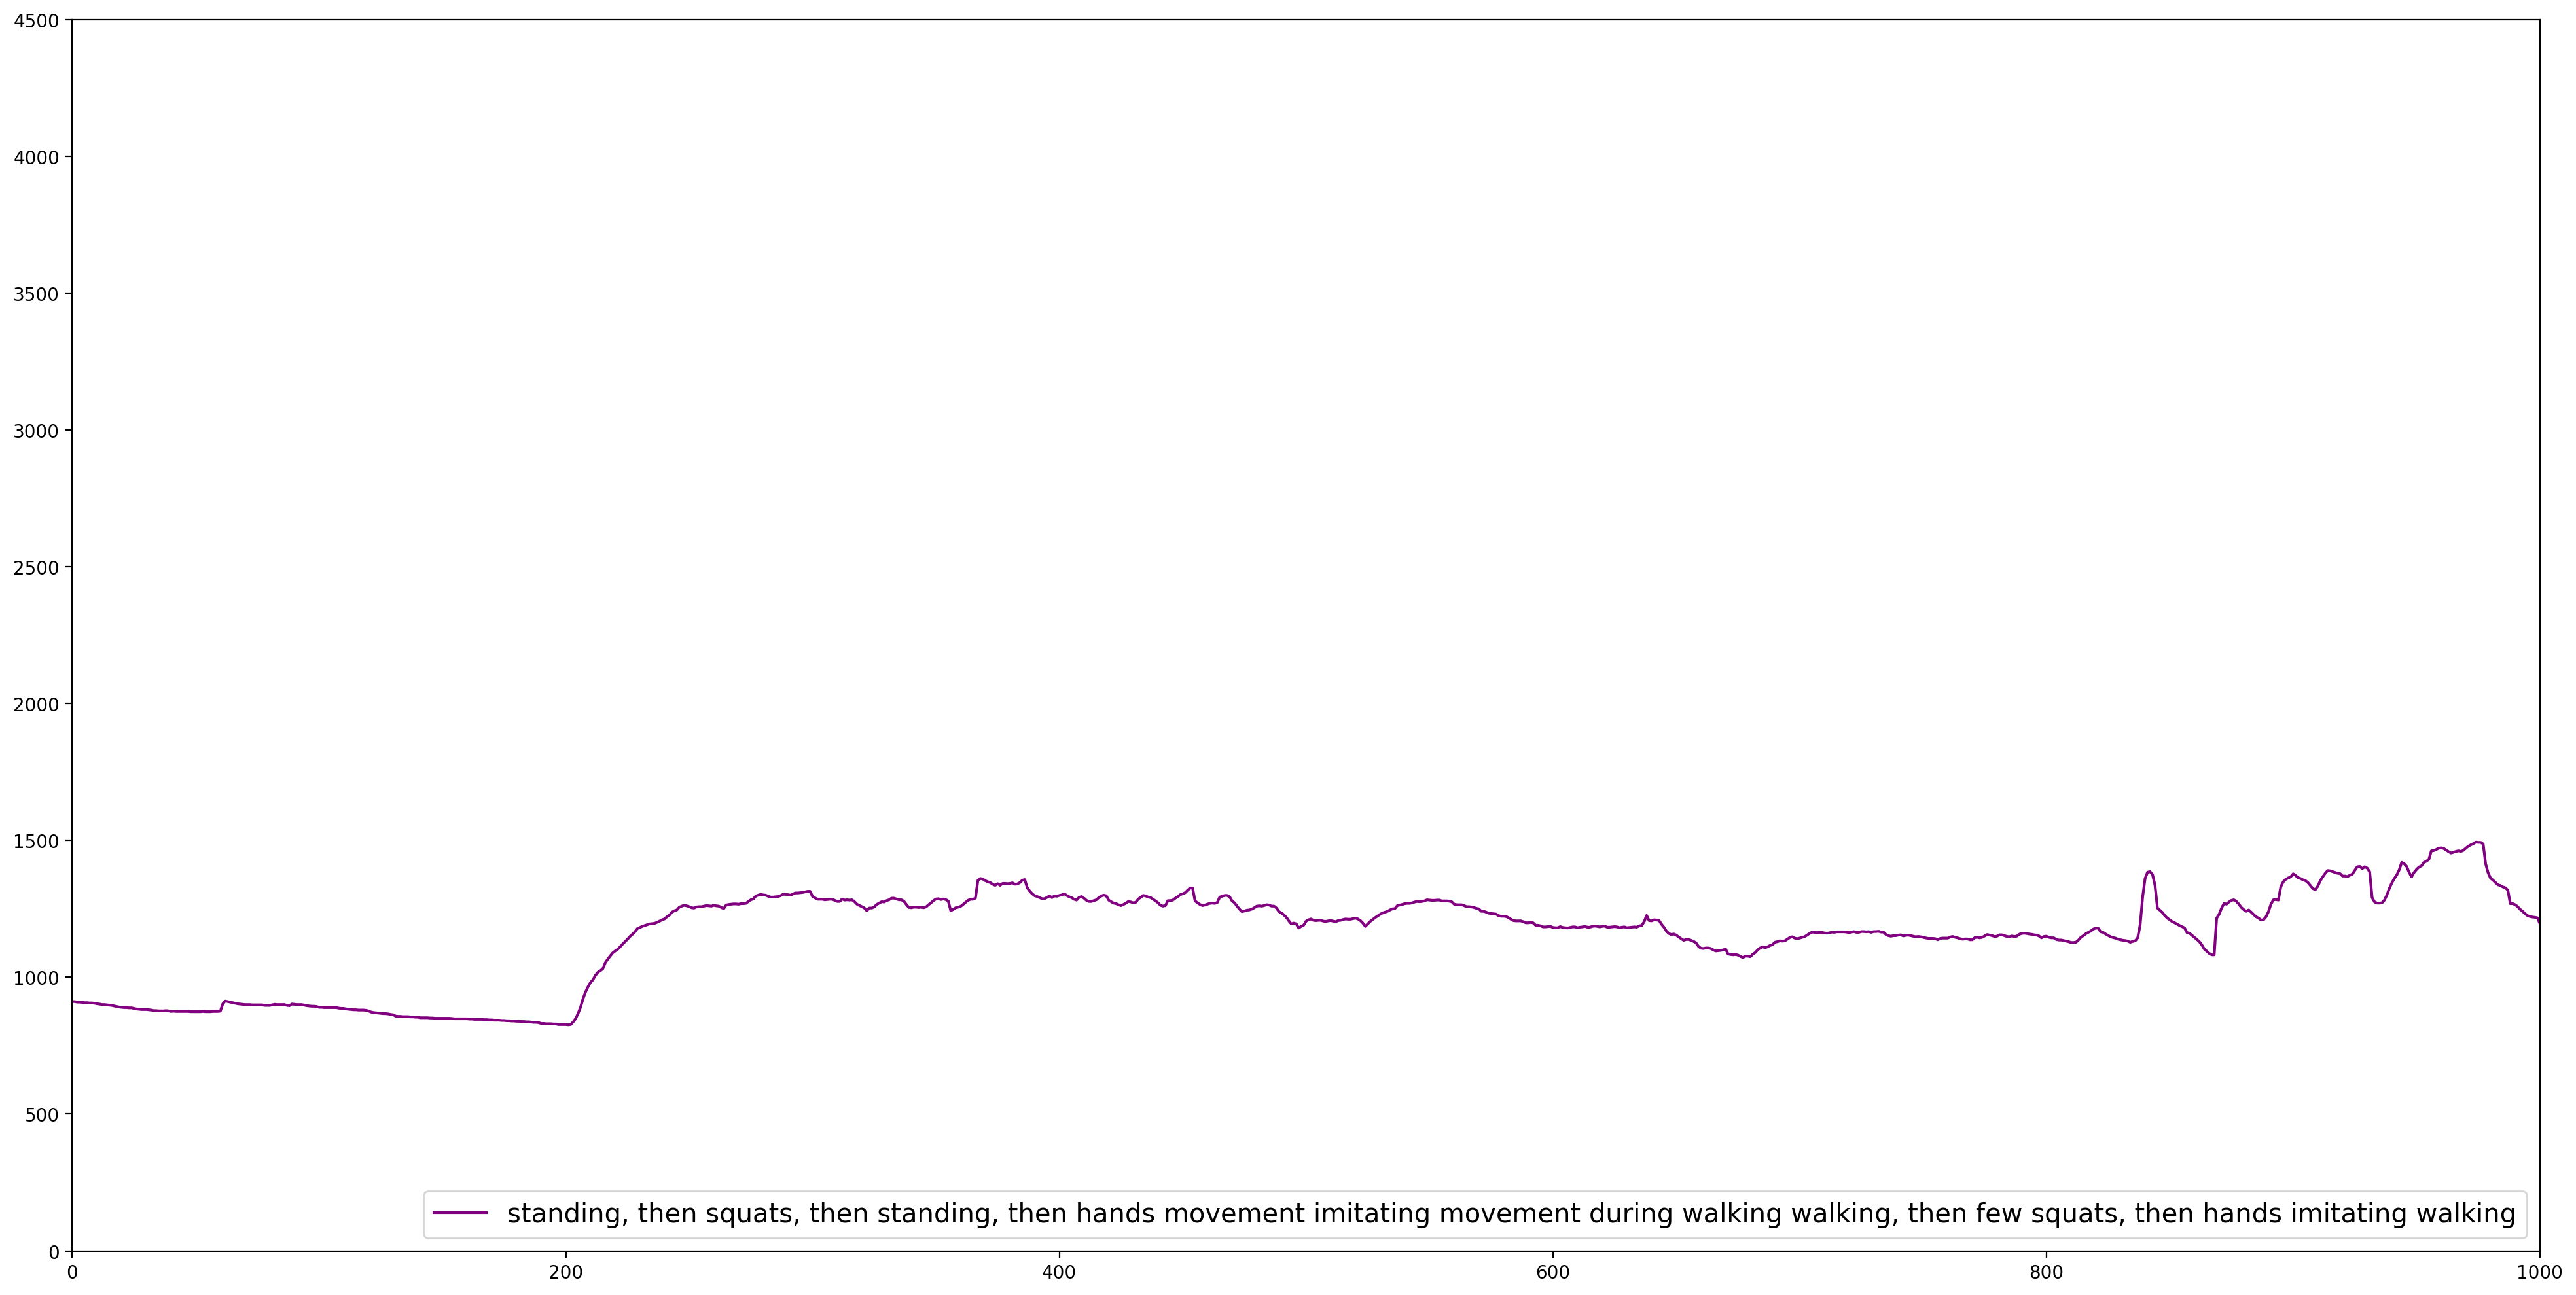

In [70]:

plt.rcParams["figure.figsize"] = [20, 6]
#plt.rcParams["figure.dpi"] = 200
plt.rcParams["legend.loc"] = 'lower right'
plt.rcParams["legend.fontsize"] = 'x-large'

#plt.rcParams["figure.autolayout"] = True
plt.plot(aggreaged_led40_steady_hand, color="red")
plt.ylim(ymin=2000,ymax=4500)
plt.xlim(xmax=1000)
plt.legend([description_led40_steady_hand])
plt.show()
plt.plot(aggreaged_led40_squeeze_palm, color="blue")
plt.ylim(ymin=2000,ymax=4500)
plt.xlim(xmax=1000)
plt.legend([description_led40_squeeze_palm])
plt.show()
plt.plot(aggreaged_led40_waving_hand, color="green")
plt.ylim(ymin=2000,ymax=4500)
plt.xlim(xmax=1000)
plt.legend([description_led40_waving_hand])
plt.show()
plt.plot(aggreaged_led40_squats_1, color="magenta")
plt.ylim(ymin=2000,ymax=4500)
plt.xlim(xmax=1000)
plt.legend([description_led40_squats_1])
plt.show()
plt.plot(aggreaged_led40_squats_2, color="black")
plt.ylim(ymin=2000,ymax=4500)
plt.xlim(xmax=1000)
plt.legend([description_led40_squats_2])
plt.show()
plt.rcParams["figure.figsize"] = [20, 10]
plt.ylim(ymin=0,ymax=4500)
plt.xlim(xmax=1000)
plt.plot(aggreaged_led12_squats_1, color="purple")
plt.legend([description_led12_squats_1])
plt.show()

# simple ppg algorithm and plot

In [119]:
import numpy as np
from scipy.signal import butter, filtfilt, find_peaks

# TODO should be done better only for estimation
def calculate_heart_rate(ppg_signal):
    time_space = np.linspace(0, len(ppg_signal)/8, len(ppg_signal))  # TODO why 8?? this is only estimation according to frequency divisin should be by 10, but 

    # Step 1: Apply a bandpass filter to remove noise
    def bandpass_filter(signal, lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        filtered_signal = filtfilt(b, a, signal)
        return filtered_signal

    fs = 10  # Sampling frequency (100 Hz)
    lowcut = 0.5  # Lower bound of heart rate (30 bpm)
    highcut = 3.0  # Upper bound of heart rate (180 bpm)
    filtered_ppg = bandpass_filter(ppg_signal, lowcut, highcut, fs)

    # Step 2: Detect peaks in the filtered PPG signal
    peaks, _ = find_peaks(filtered_ppg, distance=fs/2.5)  # Roughly expect a peak every ~0.4s (150 bpm max)

    # Step 3: Calculate heart rate from peaks
    peak_times = time_space[peaks]  # Time of each detected peak
    rr_intervals = np.diff(peak_times)  # Time between consecutive peaks (in seconds)
    heart_rate = 60 / rr_intervals  # Convert RR intervals to heart rate in bpm
    return heart_rate, time_space, peaks, filtered_ppg

In [103]:
import pylab as pl
def plot (heart_rate, time_space, peaks, filtered_ppg , ppg_signal):
    
    pl.figure(figsize=(12, 6))

    pl.subplot(2, 1, 1)
    pl.plot(time_space, ppg_signal, label='Original PPG Signal')
    pl.plot(time_space, filtered_ppg, label='Filtered PPG Signal', color='green')
    pl.plot(time_space[peaks], filtered_ppg[peaks], 'ro', label='Detected Peaks')
    pl.title('PPG Signal and Detected Peaks')
    pl.xlabel('Time [s]')
    pl.ylabel('Amplitude')
    pl.legend()

    pl.subplot(2, 1, 2)
    pl.plot(time_space[peaks][1:], heart_rate, 'b.-', label='Heart Rate (bpm)')
    pl.title('Heart Rate Over Time')
    pl.xlabel('Time [s]')
    pl.ylabel('Heart Rate [bpm]')
    pl.legend()

    pl.tight_layout()
    pl.show()

## steady hand analysis
To show simple heart rate calculation There will be only first half of signal for visibility

In [120]:

ppg_signal = aggreaged_led40_steady_hand[:int(len(aggreaged_led40_steady_hand)/2)]
ppg_signal = ppg_signal - min(ppg_signal)
heart_rate, time_space, peaks, filtered_ppg = calculate_heart_rate(ppg_signal)



70.9090909090909


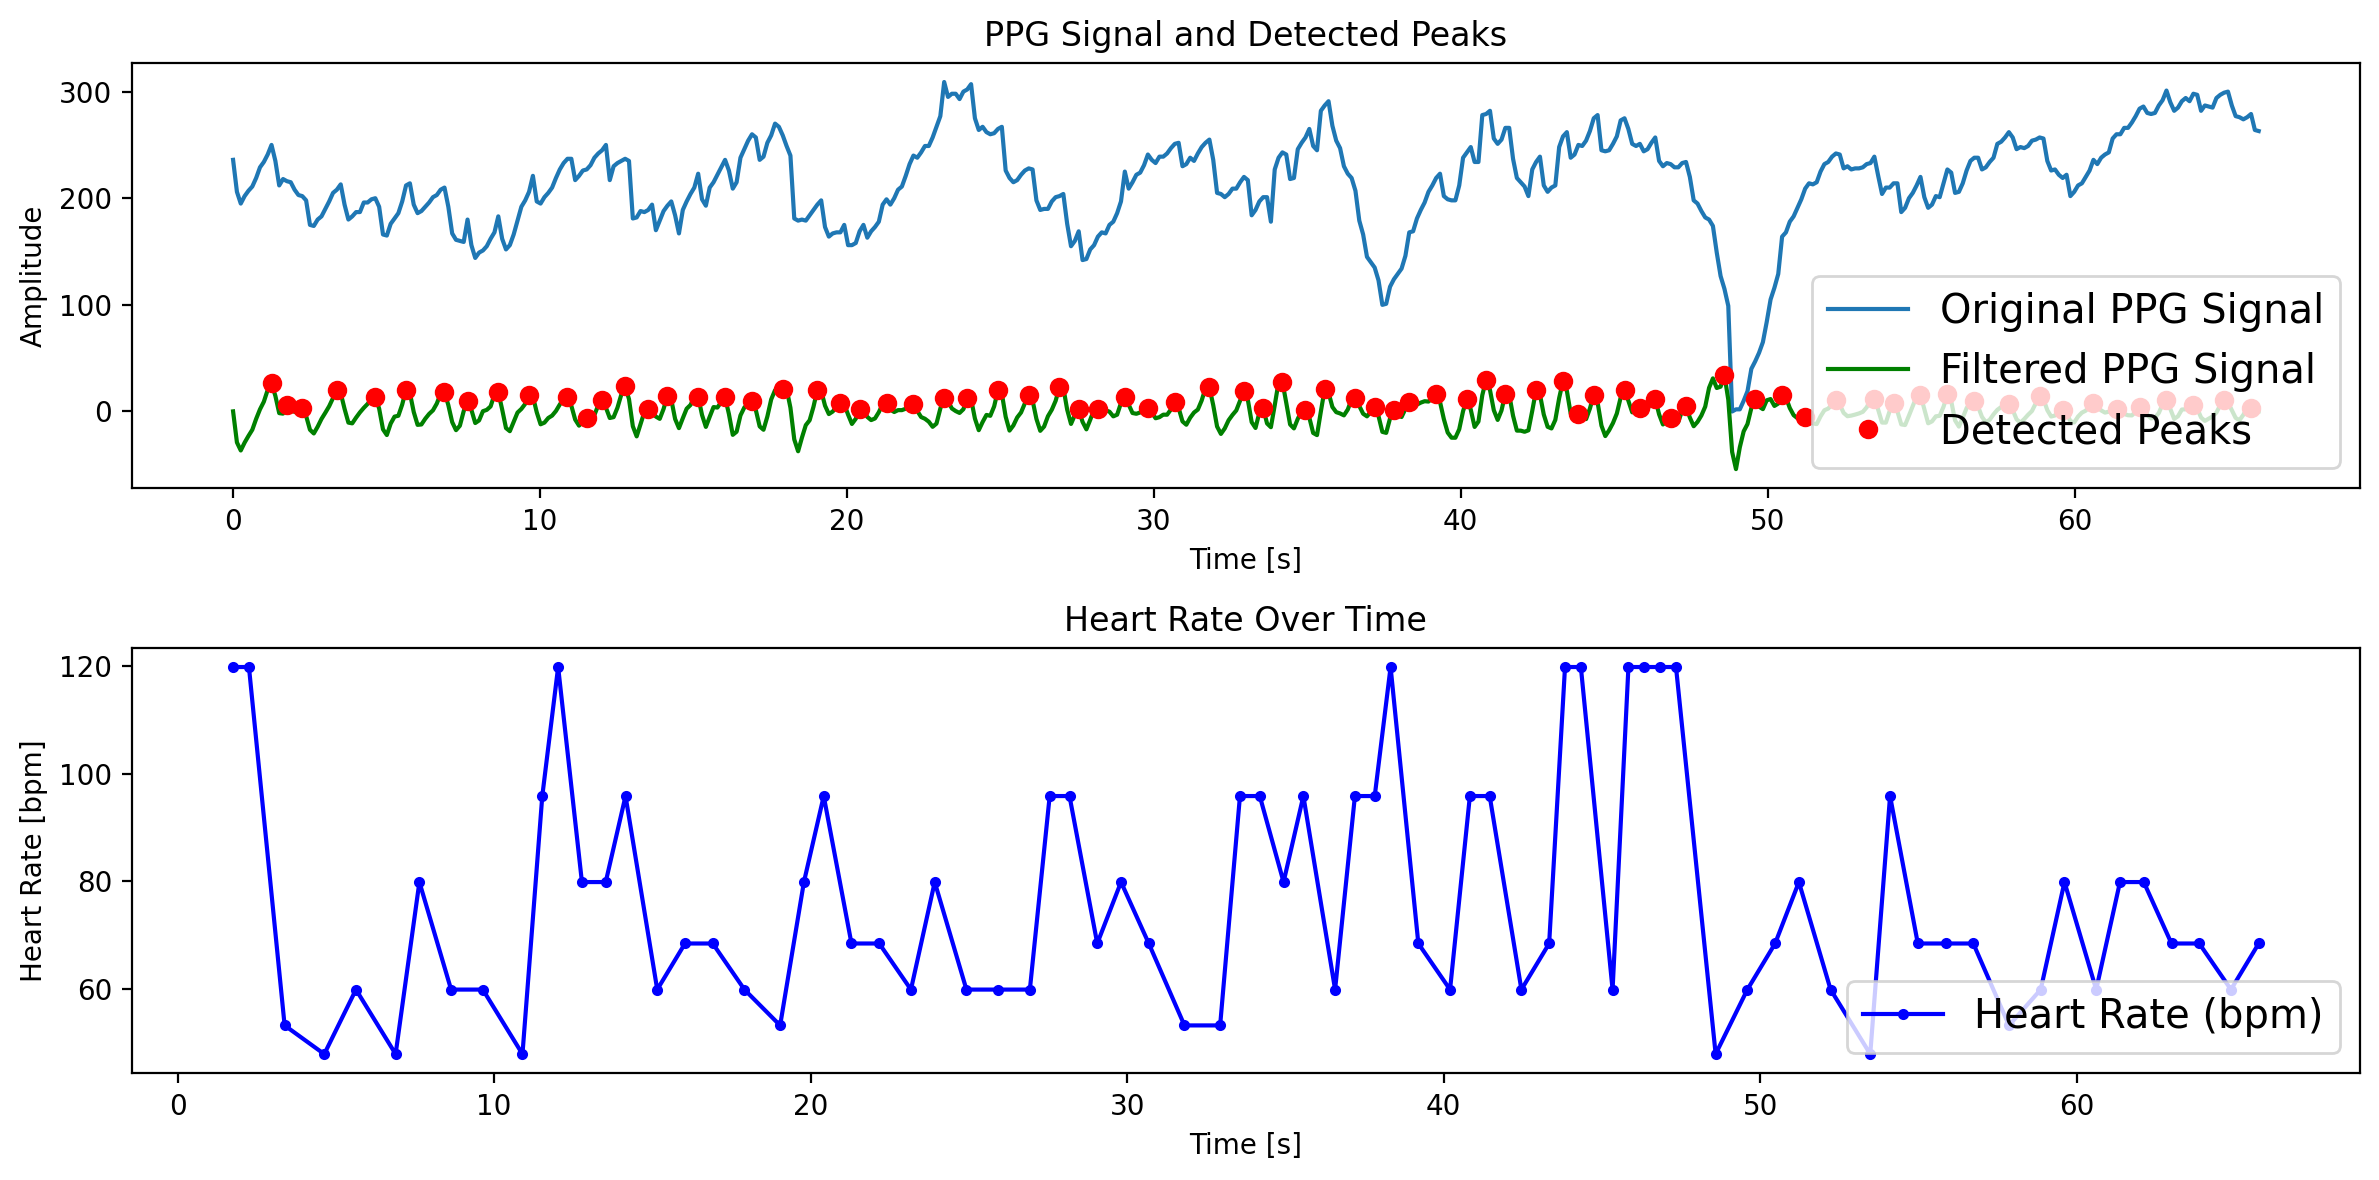

In [126]:

heartrate_val=len(peaks)/time_space[-1] * 60
print(heartrate_val)
plot (heart_rate, time_space, peaks, filtered_ppg , ppg_signal)

# aggreaged_led40_squats_1

75.23373052245647


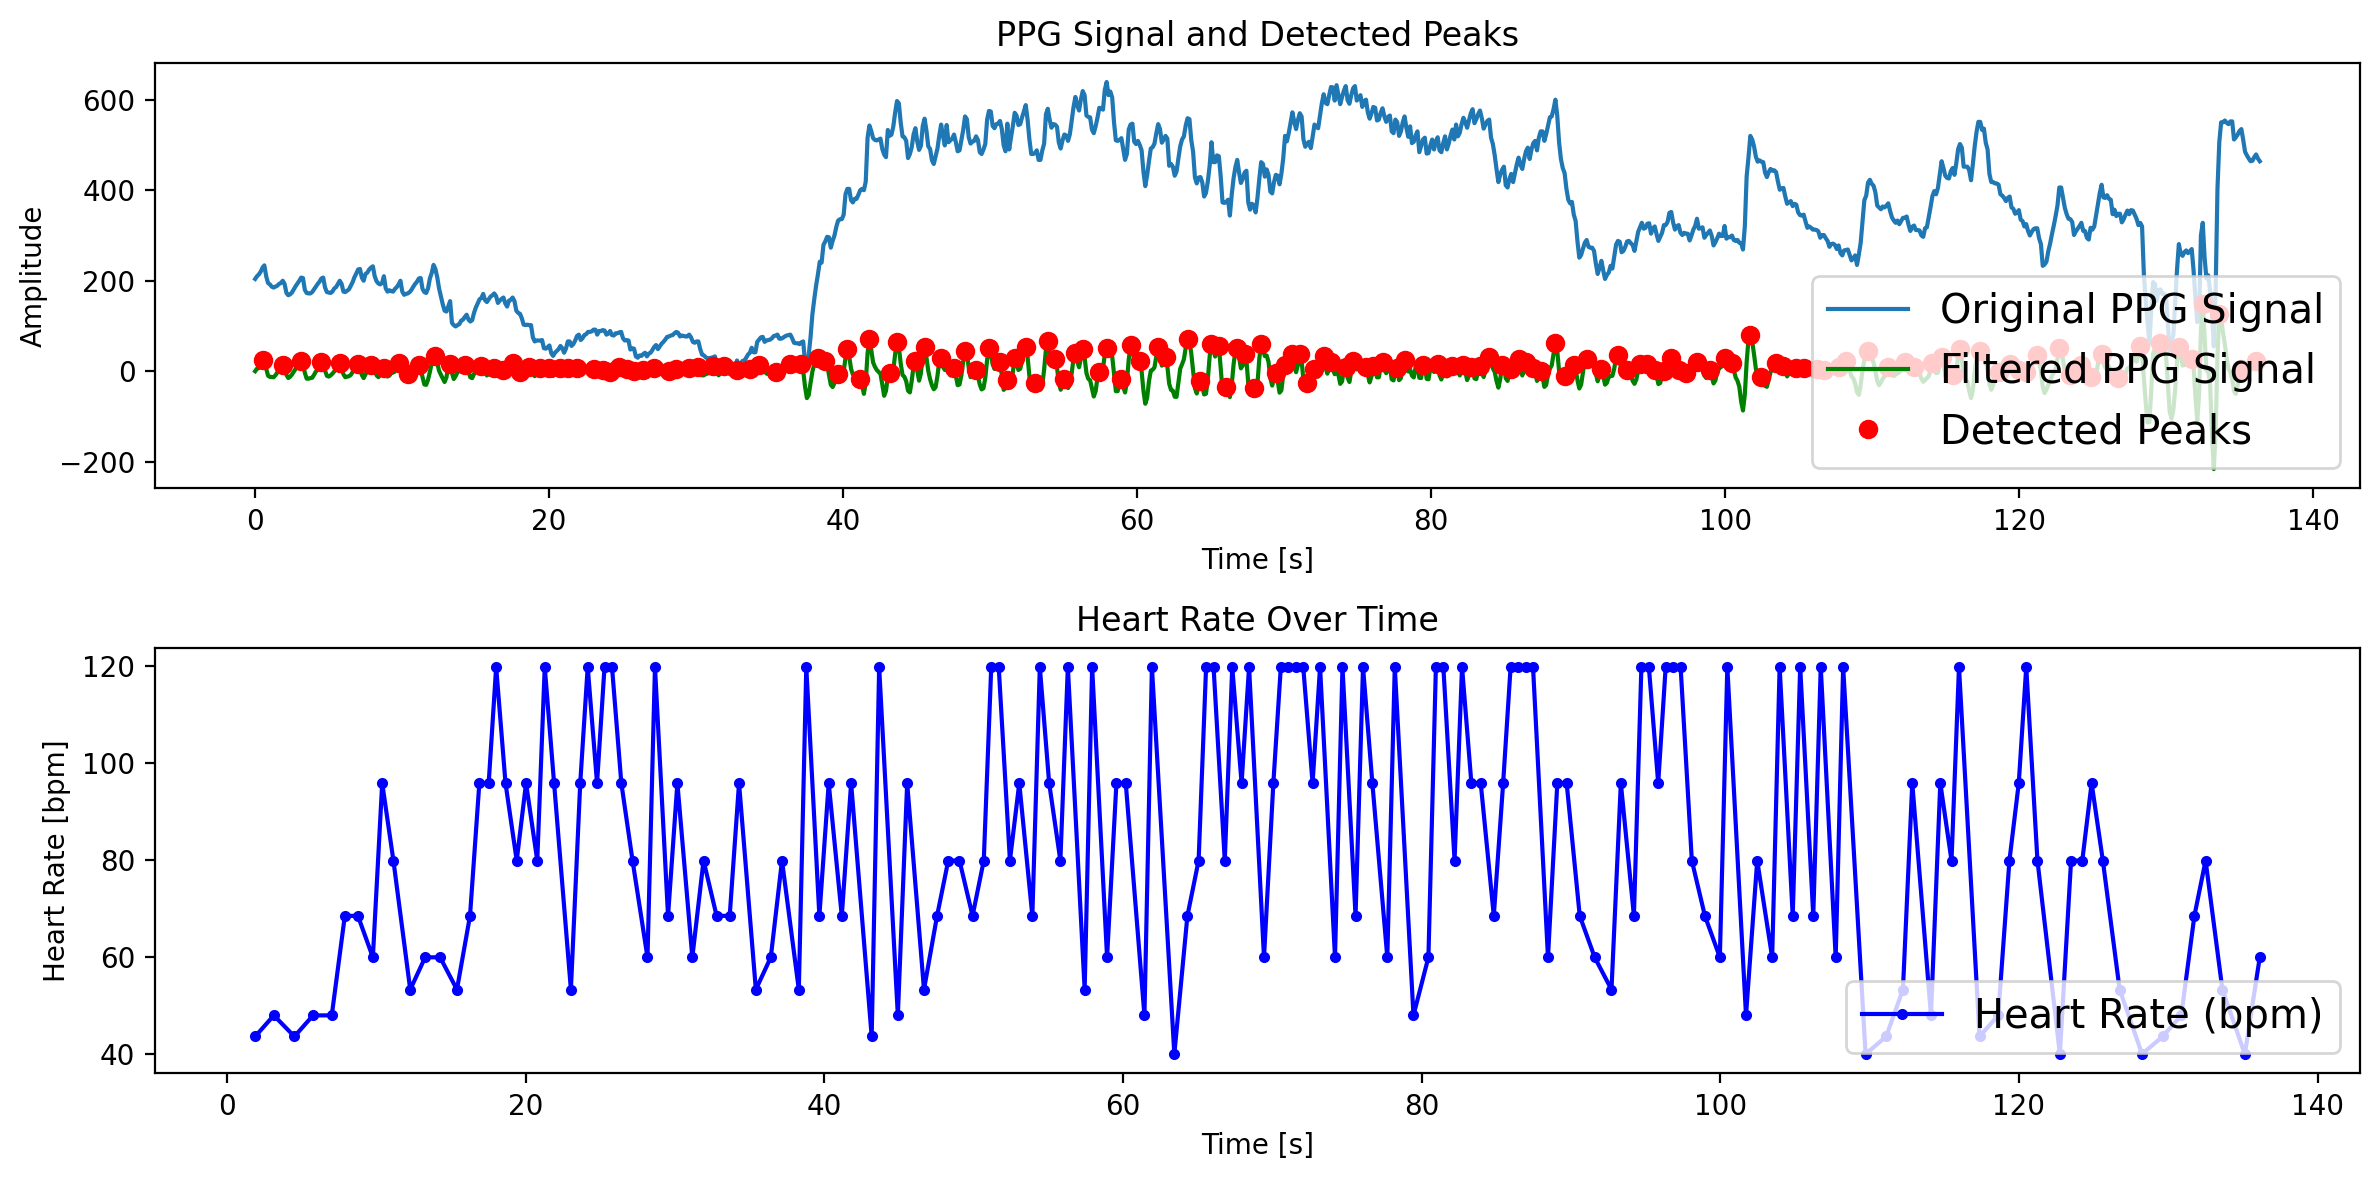

In [133]:


ppg_signal = aggreaged_led40_squats_1
ppg_signal = ppg_signal - min(ppg_signal)
heart_rate, time_space, peaks, filtered_ppg = calculate_heart_rate(ppg_signal)


heartrate_val=len(peaks)/time_space[-1] * 60
print(heartrate_val)
plot (heart_rate, time_space, peaks, filtered_ppg , ppg_signal)

# Summary
The PPG algorithm used in this analysis should be improved, so the results are not fully reliable. The collected data is not suitable for proper analysis because multiple activities were performed during recording, and it is unclear when each activity started or ended. Therefore, this analysis serves more as a proof of concept, demonstrating that PPG data collection is feasible. An important limitation not covered in the analysis is that during physical activities like walking, heart rate detection is highly inaccurate. This is likely due to interference from arm movement during walking.
## Future Work for Analysis:
   1. Improved Data Collection: More accurate data should be gathered with clear timestamps indicating when specific activities start and end.

## Future work with device
   1. Exploring Ambient Light Sensor: Investigate whether the ambient light sensor can be used to filter or clean raw PPG signals.
   2. Frequency Subtraction: Try subtracting the frequency signals from the gyroscope/accelerometer to improve the heart rate detection algorithm during movement. 
   https://sites.udel.edu/coe-engex/2020/03/07/how-garmin-watch-heart-rate-monitors-work/
   